In [1]:
import pandas as pd
import numpy as np
import math
import os,sys,re


from collections import Counter
#显示所有列
pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', None)
#设置value的显示长度为100，默认为50
pd.set_option('max_colwidth',200)

In [2]:
path = 'C:/Users/Crow/Desktop/iLearn_V2'
sys.path.append(path)


In [3]:


binBox = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

def calProb(array):
    myProb = {}
    myClass = set(array)
    for i in myClass:
        myProb[i] = array.count(i) / len(array)
    return myProb

def jointProb(newArray, labels):
    myJointProb = {}
    for i in range(len(labels)):
        myJointProb[str(newArray[i]) + '-' + str(labels[i])] = myJointProb.get(str(newArray[i]) + '-' + str(labels[i]), 0) + 1

    for key in myJointProb:
        myJointProb[key] = myJointProb[key] / len(labels)
    return myJointProb

def IG(encodings, labels):
    features = encodings[0][1:]
    encodings = np.array(encodings)[1:]
    data = encodings[:, 1:]
    shape = data.shape
    data = np.reshape(data, shape[0] * shape[1])
    data = np.reshape([float(i) for i in data], shape)

    e = ''
    if shape[0] < 5 or shape[1] < 2:
        return 0, e

    dataShape = data.shape

    if dataShape[1] != len(features):
        print('Error: inconsistent data shape with feature number.')
        return 0, 'Error: inconsistent data shape with feature number.'

    if dataShape[0] != len(labels):
        print('Error: inconsistent data shape with sample number.')
        return 0, 'Error: inconsistent data shape with sample number.'

    sampleNumber = len(data)
    labelClass = set(labels)
    probY = calProb(labels)

    myFea = {}
    for i in range(len(features)):
        array = data[:, i]
        newArray = list(pd.cut(array, len(binBox), labels= binBox))
        binBoxClass = set(newArray)

        probX = calProb(newArray)
        probXY = jointProb(newArray, labels)
        HX = -1 * sum([p * math.log(p, 2) for p in probX.values()])
        HXY = 0
        for y in probY.keys():
            for x in probX.keys():
                if str(x) + '-' + str(y) in probXY:
                    HXY = HXY + (probXY[str(x) + '-' + str(y)] * math.log(probXY[str(x) + '-' + str(y)] / probY[y], 2))
        myFea[features[i]] = HX + HXY

    res = []
    res.append(['feature', 'IG-value'])
    for key in sorted(myFea.items(), key=lambda item:item[1], reverse=True):
        res.append([key[0], '{0:.3f}'.format(myFea[key[0]])])
    return res, e


In [4]:
def readFastas2Dict(file):
    if os.path.exists(file) == False:
        print('Error: "' + file + '" does not exist.')
        sys.exit(1)

    with open(file) as f:
        records = f.read()

    if re.search('>', records) == None:
        print('The input file seems not in fasta format.')
        sys.exit(1)

    records = records.split('>')[1:]
    myFasta = {}
    for fasta in records:
        array = fasta.split('\n')
        name, sequence = array[0].split()[0], ''.join(array[1:]).upper()
    myFasta[name] = sequence
    return myFasta

In [5]:
def readFasta(file):
    if os.path.exists(file) == False:
        print('Error: "' + file + '" does not exist.')
        sys.exit(1)

    with open(file) as f:
        records = f.read()

    if re.search('>', records) == None:
        print('The input file seems not in fasta format.')
        sys.exit(1)

    records = records.split('>')[1:]
    myFasta = []
    for fasta in records:
        array = fasta.split('\n')
        name, sequence = array[0].split()[0], re.sub('[^ARNDCQEGHILKMFPSTWYV-]', '-', ''.join(array[1:]).upper())
        myFasta.append([name, sequence])
    return myFasta

In [6]:
def read_protein_sequences(file):
    if os.path.exists(file) == False:
        print('Error: file %s does not exist.' % file)
        sys.exit(1)
    with open(file) as f:
        records = f.read()
    if re.search('>', records) == None:
        print('Error: the input file %s seems not in FASTA format!' % file)
        sys.exit(1)
    records = records.split('>')[1:]
    fasta_sequences = []
    for fasta in records:
        array = fasta.split('\n')
        header, sequence = array[0].split()[0], re.sub('[^ACDEFGHIKLMNPQRSTVWY-]', '-', ''.join(array[1:]).upper())
        header_array = header.split('|')
        name = header_array[0]
        label = header_array[1] if len(header_array) >= 1 else '0'
        label_train = header_array[2] if len(header_array) >= 2 else 'training'
        fasta_sequences.append([name, sequence, label, label_train])
    return fasta_sequences

In [7]:
def GAAC(fastas, **kw):
    group = {
        'alphatic': 'GAVLMI',
        'aromatic': 'FYW',
        'postivecharge': 'KRH',
        'negativecharge': 'DE',
        'uncharge': 'STCPNQ'
    }

    groupKey = group.keys()

    encodings = []
    header = ['#', 'label']
    for key in groupKey:
        header.append(key)
    encodings.append(header)

    for i in fastas:
        name, sequence, label = i[0], re.sub('-', '', i[1]), i[2]
        code = [name, label]
        count = Counter(sequence)
        myDict = {}
        for key in groupKey:
            for aa in group[key]:
                myDict[key] = myDict.get(key, 0) + count[aa]

        for key in groupKey:
            code.append(myDict[key]/len(sequence))
        encodings.append(code)

    return encodings

In [8]:
def EGAAC(fastas, window=5, **kw):
    if window < 1:
        print('Error: the sliding window should be greater than zero' + '\n\n')
        return 0

    group = {
        'alphaticr': 'GAVLMI',
        'aromatic': 'FYW',
        'postivecharger': 'KRH',
        'negativecharger': 'DE',
        'uncharger': 'STCPNQ'
    }

    groupKey = group.keys()

    encodings = []
    header = ['#', 'label']
    for w in range(1, len(fastas[0][1]) - window + 2):
        for g in groupKey:
            header.append('SW.' + str(w) + '.' + g)

    encodings.append(header)

    for i in fastas:
        name, sequence, label = i[0], i[1], i[2]
        code = [name, label]
        for j in range(len(sequence)):
            if j + window <= len(sequence):
                count = Counter(sequence[j:j + window])
                myDict = {}
                for key in groupKey:
                    for aa in group[key]:
                        myDict[key] = myDict.get(key, 0) + count[aa]
                for key in groupKey:
                    code.append(myDict[key] / window)
        encodings.append(code)
    return encodings

In [9]:
def CKSAAP(fastas, gap=5, **kw):
    if gap < 0:
        print('Error: the gap should be equal or greater than zero' + '\n\n')
        return 0

    

    AA = kw['order'] if kw['order'] != None else 'ACDEFGHIKLMNPQRSTVWY'
    encodings = []
    aaPairs = []
    for aa1 in AA:
        for aa2 in AA:
            aaPairs.append(aa1 + aa2)

    header = ['#', 'label']
    for g in range(gap + 1):
        for aa in aaPairs:
            header.append(aa + '.gap' + str(g))
    encodings.append(header)

    for i in fastas:
        name, sequence, label = i[0], i[1], i[2]
        code = [name, label]
        for g in range(gap + 1):
            myDict = {}
            for pair in aaPairs:
                myDict[pair] = 0
            sum = 0
            for index1 in range(len(sequence)):
                index2 = index1 + g + 1
                if index1 < len(sequence) and index2 < len(sequence) and sequence[index1] in AA and sequence[
                    index2] in AA:
                    myDict[sequence[index1] + sequence[index2]] = myDict[sequence[index1] + sequence[index2]] + 1
                    sum = sum + 1
            for pair in aaPairs:
                code.append(myDict[pair] / sum)
        encodings.append(code)
    return encodings

In [10]:
def AAC(fastas, **kw):
    #AA = kw['order'] if kw['order'] != None else 'ACDEFGHIKLMNPQRSTVWY'
    AA = 'ACDEFGHIKLMNPQRSTVWY'
    encodings = []
    header = ['#', 'label']
    for i in AA:
        header.append(i)
    encodings.append(header)

    for i in fastas:
        name, sequence, label = i[0], re.sub('-', '', i[1]), i[2]
        count = Counter(sequence)
        for key in count:
            count[key] = count[key]/len(sequence)
        code = [name, label]
        for aa in AA:
            code.append(count[aa])
        encodings.append(code)
    return encodings

In [11]:
def binary(fastas, **kw):
    AA = 'ARNDCQEGHILKMFPSTWYV'
    encodings = []
    header = ['#', 'label']
    for i in range(1, len(fastas[0][1]) * 20 + 1):
        header.append('BINARY.F'+str(i))
    encodings.append(header)

    for i in fastas:
        name, sequence, label = i[0], i[1], i[2]
        code = [name, label]
        for aa in sequence:
            if aa == '-':
                code = code + [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
                continue
            for aa1 in AA:
                tag = 1 if aa == aa1 else 0
                code.append(tag)
        encodings.append(code)
    return encodings

In [12]:
def save_file(encodings, format='svm', file='encodings.txt'):
    if encodings == 0:
        with open(file, 'w') as f:
            f.write('An error encountered.')
    else:
        if format == 'svm':
            write_to_svm(encodings, file)
        if format == 'tsv':
            write_to_tsv(encodings, file)
        if format == 'csv':
            write_to_csv(encodings, file)
        if format == 'weka':
            write_to_weka(encodings, file)
        if format == 'tsv_1':
            write_to_tsv_1(encodings, file)

In [13]:
def write_to_svm(encodings, file):
    with open(file, 'w') as f:
        for line in encodings[1:]:
            line = line[1:]
            f.write('%s' % line[0])
            for i in range(1, len(line)):
                f.write('  %d:%s' % (i, line[i]))
            f.write('\n')

In [14]:
def EAAC(fastas, window=5, **kw):
    if window < 1:
        print('Error: the sliding window should be greater than zero' + '\n\n')
        return 0

    
    #AA = kw['order'] if kw['order'] != None else 'ACDEFGHIKLMNPQRSTVWY'
    AA = 'ARNDCQEGHILKMFPSTWYV'
    encodings = []
    header = ['#', 'label']
    for w in range(1, len(fastas[0][1]) - window + 2):
        for aa in AA:
            header.append('SW.'+str(w)+'.'+aa)
    encodings.append(header)

    for i in fastas:
        name, sequence, label = i[0], i[1], i[2]
        code = [name, label]
        for j in range(len(sequence)):
            if j < len(sequence) and j + window <= len(sequence):
                count = Counter(sequence[j:j+window])
                for key in count:
                    count[key] = count[key] / len(sequence[j:j+window])
                for aa in AA:
                    code.append(count[aa])
        encodings.append(code)
    return encodings


In [15]:
def ZSCALE(fastas, **kw):
    zscale = {
        'A': [0.24,  -2.32,  0.60, -0.14,  1.30], # A
        'C': [0.84,  -1.67,  3.71,  0.18, -2.65], # C
        'D': [3.98,   0.93,  1.93, -2.46,  0.75], # D
        'E': [3.11,   0.26, -0.11, -0.34, -0.25], # E
        'F': [-4.22,  1.94,  1.06,  0.54, -0.62], # F
        'G': [2.05,  -4.06,  0.36, -0.82, -0.38], # G
        'H': [2.47,   1.95,  0.26,  3.90,  0.09], # H
        'I': [-3.89, -1.73, -1.71, -0.84,  0.26], # I
        'K': [2.29,   0.89, -2.49,  1.49,  0.31], # K
        'L': [-4.28, -1.30, -1.49, -0.72,  0.84], # L
        'M': [-2.85, -0.22,  0.47,  1.94, -0.98], # M
        'N': [3.05,   1.62,  1.04, -1.15,  1.61], # N
        'P': [-1.66,  0.27,  1.84,  0.70,  2.00], # P
        'Q': [1.75,   0.50, -1.44, -1.34,  0.66], # Q
        'R': [3.52,   2.50, -3.50,  1.99, -0.17], # R
        'S': [2.39,  -1.07,  1.15, -1.39,  0.67], # S
        'T': [0.75,  -2.18, -1.12, -1.46, -0.40], # T
        'V': [-2.59, -2.64, -1.54, -0.85, -0.02], # V
        'W': [-4.36,  3.94,  0.59,  3.44, -1.59], # W
        'Y': [-2.54,  2.44,  0.43,  0.04, -1.47], # Y
        '-': [0.00,   0.00,  0.00,  0.00,  0.00], # -
    }
    encodings = []
    header = ['#', 'label']
    for p in range(1, len(fastas[0][1])+1):
        for z in ('1', '2', '3', '4', '5'):
            header.append('Pos'+str(p) + '.ZSCALE' + z)
    encodings.append(header)

    for i in fastas:
        name, sequence, label = i[0], i[1], i[2]
        code = [name, label]
        for aa in sequence:
            code = code + zscale[aa]
        encodings.append(code)
    return encodings

In [16]:
# train data to EGAAC for SVM format

train_data37_path = 'C:/Users/Crow/Desktop/human_data/Step_11_CV/Train_37.fasta'
fastas = read_protein_sequences(train_data37_path)
encodings = EGAAC(fastas, window=4)
write_to_svm(encodings, 'C:/Users/Crow/Desktop/human_data/Step_11_CV/Train_37_EGAAC.fasta')


KeyboardInterrupt: 

In [ ]:
#EGAAC 循环编码
name = 'plant_data_12.12'
size = [21,23,25,27,29,31,35,37]
winsize = 4
for i in size:
    # train
    train_data = 'C:/Users/Crow/Desktop/'+ name +'/Step_11_CV/Train_'+str(i)+'.fasta'
    fastas = read_protein_sequences(train_data)
    encodings = EGAAC(fastas, window=winsize)
    write_to_svm(encodings, 'C:/Users/Crow/Desktop/'+ name +'/Step_11_CV/EGAAC/Train_'+str(i)+'_EGAAC_gap'+str(winsize)+'.txt')
    # test
    test_data = 'C:/Users/Crow/Desktop/'+ name +'/Step_11_IND/Test_'+str(i)+'.fasta'
    fastas = read_protein_sequences(test_data)
    encodings = EGAAC(fastas, window=winsize)
    write_to_svm(encodings, 'C:/Users/Crow/Desktop/'+ name +'/Step_11_IND/EGAAC/Test_'+str(i)+'_EGAAC_gap'+str(winsize)+'.txt')


In [ ]:
# CKSAAP循环编码
#name = 'human_data_12.12'
name = 'plant_data_12.12'
size = [21,23,25,27,29,31,35,37]
kw = {'order': 'ACDEFGHIKLMNPQRSTVWY'}
for winsize in range(4,5):
    for i in size:
        train_data = 'C:/Users/Crow/Desktop/'+ name +'/Step_11_CV/Train_'+str(i)+'.fasta'
        fastas = read_protein_sequences(train_data)
        encodings = CKSAAP(fastas, gap=winsize, **kw)
        write_to_svm(encodings, 'C:/Users/Crow/Desktop/'+ name +'/Step_11_CV/CKSAAP/Train_'+str(i)+'_CKSAAP_gap'+str(winsize)+'.txt')
        # test
        test_data = 'C:/Users/Crow/Desktop/'+ name +'/Step_11_IND/Test_'+str(i)+'.fasta'
        fastas = read_protein_sequences(test_data)
        encodings = CKSAAP(fastas, gap=winsize, **kw)
        write_to_svm(encodings, 'C:/Users/Crow/Desktop/'+ name +'/Step_11_IND/CKSAAP/Test_'+str(i)+'_CKSAAP_gap'+str(winsize)+'.txt')
        
       


In [ ]:
# EAAC 循环编码
#name = 'human_data_12.12'
name = 'plant_data_12.12'
size = [21,23,25,27,29,31,35,37]
winsize = 5
kw = {'order': 'ACDEFGHIKLMNPQRSTVWY'}
for i in size:
    # train
    train_data = 'C:/Users/Crow/Desktop/'+ name +'/Step_11_CV/Train_'+str(i)+'.fasta'
    fastas = read_protein_sequences(train_data)
    encodings = EAAC(fastas,winsize)
    write_to_svm(encodings, 'C:/Users/Crow/Desktop/'+ name +'/Step_11_CV/EAAC/Train_'+str(i)+'_EAAC_gap'+str(winsize)+'.txt')
    # test
    test_data = 'C:/Users/Crow/Desktop/'+ name +'/Step_11_IND/Test_'+str(i)+'.fasta'
    fastas = read_protein_sequences(test_data)
    encodings = EAAC(fastas,winsize)
    write_to_svm(encodings, 'C:/Users/Crow/Desktop/'+ name +'/Step_11_IND/EAAC/Test_'+str(i)+'_EAAC_gap'+str(winsize)+'.txt')

In [ ]:
# AAC 循环编码
#name = 'human_data_12.12'
name = 'plant_data_12.12'
size = [21,23,25,27,29,31,35,37]
for i in size:
    # train
    train_data = 'C:/Users/Crow/Desktop/'+ name +'/Step_11_CV/Train_'+str(i)+'.fasta'
    fastas = read_protein_sequences(train_data)
    encodings = AAC(fastas)
    write_to_svm(encodings, 'C:/Users/Crow/Desktop/'+ name +'/Step_11_CV/AAC/Train_'+str(i)+'_AAC.txt')
    # test
    test_data = 'C:/Users/Crow/Desktop/'+ name +'/Step_11_IND/Test_'+str(i)+'.fasta'
    fastas = read_protein_sequences(test_data)
    encodings = AAC(fastas)
    write_to_svm(encodings, 'C:/Users/Crow/Desktop/'+ name +'/Step_11_IND/AAC/Test_'+str(i)+'_AAC.txt')

In [ ]:
# Binary 循环编码
#name = 'human_data_12.12'
name = 'plant_data_12.12'
size = [21,23,25,27,29,31,35,37]
for i in size:
    # train
    train_data = 'C:/Users/Crow/Desktop/'+ name +'/Step_11_CV/Train_'+str(i)+'.fasta'
    fastas = read_protein_sequences(train_data)
    encodings = binary(fastas)
    write_to_svm(encodings, 'C:/Users/Crow/Desktop/'+ name +'/Step_11_CV/BINARY/Train_'+str(i)+'_BINARY.txt')
    # test
    test_data = 'C:/Users/Crow/Desktop/'+ name +'/Step_11_IND/Test_'+str(i)+'.fasta'
    fastas = read_protein_sequences(test_data)
    encodings = binary(fastas)
    write_to_svm(encodings, 'C:/Users/Crow/Desktop/'+ name +'/Step_11_IND/BINARY/Test_'+str(i)+'_BINARY.txt')

In [ ]:
# ZSCALE 循环编码
#name = 'human_data_12.12'
name = 'plant_data_12.12'
size = [21,23,25,27,29,31,35,37]
for i in size:
    # train
    train_data = 'C:/Users/Crow/Desktop/'+ name +'/Step_11_CV/Train_'+str(i)+'.fasta'
    fastas = read_protein_sequences(train_data)
    encodings = ZSCALE(fastas)
    write_to_svm(encodings, 'C:/Users/Crow/Desktop/'+ name +'/Step_11_CV/ZSCALE/Train_'+str(i)+'_ZSCALE.txt')
    # test
    test_data = 'C:/Users/Crow/Desktop/'+ name +'/Step_11_IND/Test_'+str(i)+'.fasta'
    fastas = read_protein_sequences(test_data)
    encodings = ZSCALE(fastas)
    write_to_svm(encodings, 'C:/Users/Crow/Desktop/'+ name +'/Step_11_IND/ZSCALE/Test_'+str(i)+'_ZSCALE.txt')

In [14]:
fastas = read_protein_sequences('C:/Users/Crow/Desktop/human_data_12.12/Step_11_CV/Train_29.fasta')
encodings = GAAC(fastas)
write_to_svm(encodings, 'C:/Users/Crow/Desktop/human_data_12.12/Step_11_CV/GAAC/Train_29_GAAC.txt')

In [16]:
fastas = read_protein_sequences('C:/Users/Crow/Desktop/human_data_12.12/Step_11_IND/Test_29.fasta')
encodings = GAAC(fastas)
write_to_svm(encodings, 'C:/Users/Crow/Desktop/human_data_12.12/Step_11_IND/GAAC/Test_29_GAAC.txt')

In [ ]:
fr = open('C:/Users/Crow/Desktop/human_data_12.12/Step_11_IND/Test_29.fasta', 'r')



In [19]:
data = readFasta("C:/Users/Crow/Desktop/human_data_12.12/Test_31.fasta")


In [18]:
data[0:5]

[['A6NDG6_80|1|testing', 'FITNNSSKTRAAYAEKLRRLGFGGPAGPGAS'],
 ['A6NEN9_177|1|testing', 'RNRPDFRKNKGRQLNKTTKQKK---------'],
 ['B1AJZ9_513|1|testing', 'QVIKATYGRAKPFRDKPVTDQQLIEKITQVT'],
 ['O00116_454|1|testing', 'IFTSFLDGLKKFYITKFKGFDPNQLSVATLL'],
 ['O00116_476|1|testing', 'NQLSVATLLFEGDREKVLQHEKQVYDIAAKF']]

In [ ]:
data[0][0].replace("''","")

In [ ]:

fw = open('C:/Users/Crow/Desktop/CKSAAP_CrotSite2/'+ '0' +'.fasta', 'w')
fw.write('>')
fw.write(data[0][0])

fw.close()

In [ ]:
fw.close()

In [14]:
data = readFasta('C:/Users/Crow/Desktop/human_data_12.12/Test_29.fasta')
# 数据分解10份
s = 1
fw = open('C:/Users/Crow/Desktop/CKSAAP_CrotSite_29/'+ str(0) +'.fasta', 'w')
for i in range(0,len(data)):
    fw.write('>')
    fw.write(data[i][0])
    fw.write('\n')
    fw.write(data[i][1])
    fw.write('\n')
    if s%1000 == 0:
        fw.close()
        fw = open('C:/Users/Crow/Desktop/CKSAAP_CrotSite_29//'+ str(s) +'.fasta', 'w')
    s+=1
fw.close()

In [13]:
# 读取histone.txt文件  输出fasta格式
histone_data = pd.read_table('C:/Users/Crow/Desktop/histone.txt',names=['Sequences', 'Protein ID', 'Site', 'Label'])

#histone_data[0:169]
fw = open('C:/Users/Crow/Desktop/histone_p.fasta','w')
for i in range(169):
    fw.write('>'+histone_data['Protein ID'][i]+ '_' + str(histone_data['Site'][i]) + '_'+ str(histone_data['Label'][i]))
    fw.write('\n')
    fw.write(histone_data['Sequences'][i])
    fw.write('\n')
fw.close()

#histone_data[169:]
fw = open('C:/Users/Crow/Desktop/histone_n.fasta','w')
for i in range(169,len(histone_data)):
    fw.write('>'+histone_data['Protein ID'][i]+ '_' + str(histone_data['Site'][i]) + '_'+ str(histone_data['Label'][i]))
    fw.write('\n')
    fw.write(histone_data['Sequences'][i])
    fw.write('\n')
fw.close()


C:\Users\Crow\AppData\Local\conda\conda\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  


In [29]:
# 分割并序列编码
AA = 'GAVLIFWYDNEKQMSTCPHR'
def pep(path, seq_len):
    seqs = open(path).readlines()
    cut = (len(seqs[0].split()[0]) - 1 - seq_len) // 2
    X = [[AA.index(res.upper()) if res.upper() in AA else 0
          for res in (seq.split()[0][cut:-cut] if cut != 0 else seq.split()[0])]
        for seq in seqs if seq.strip() != '']
    y = [int(seq.split()[-1]) for seq in seqs if seq.strip() != '']
    return np.array(X), np.array(y)

path_train = 'C:/Users/Crow/Desktop/human_data_12.12/Train.txt'
path_test =  'C:/Users/Crow/Desktop/human_data_12.12/Independent.txt'

x_train,y_train = pep(path_train,27)
x_test,y_test = pep(path_test,27)

In [30]:
x_train[0:5]

array([[ 0, 19,  4,  7, 10,  3, 19,  3, 13, 13,  8,  5,  8,  0, 11,  9,
        19,  0,  7,  1,  5,  2, 13,  7, 16, 18, 11, 18, 10],
       [10,  0, 14, 16,  3, 10,  2, 15,  3,  1, 11, 17,  2,  8, 11, 10,
        12,  7, 14, 19,  7, 12, 11,  1,  1, 19,  0,  0,  0],
       [ 7, 14,  1,  0, 19,  0,  4,  7, 14, 19,  7, 18, 10,  0, 11,  0,
        11, 12, 12, 10, 11,  0,  7, 10,  3,  2, 17,  9,  3],
       [ 2,  3,  9, 14, 10,  2,  3, 10, 12, 19, 11,  2,  3, 10, 11, 16,
         9, 19,  2, 14, 13,  3,  1,  2, 10, 10,  7, 10, 10],
       [12,  3, 10,  3,  3, 10, 10,  8, 11, 11, 10,  3, 10,  3, 11,  7,
        12,  9, 14, 10, 10, 11,  1, 19,  9,  3, 11, 18, 14]])

In [134]:
fastas = read_protein_sequences('C:/Users/Crow/Desktop/human_data_12.12/Step_11_CV/Train_29.fasta')
encodings = EGAAC(fastas, window=4)

In [28]:
np.array(encodings)[1:][0:10]

array([['A0AV96_109', '1', '0.5', ..., '0.75', '0.25', '0.0'],
       ['A0AV96_321', '1', '0.25', ..., '0.25', '0.0', '0.0'],
       ['A0AV96_415', '1', '0.5', ..., '0.0', '0.0', '0.5'],
       ...,
       ['A4D1E9_356', '1', '0.25', ..., '0.0', '0.0', '0.75'],
       ['A5YKK6_877', '1', '0.5', ..., '0.0', '0.0', '0.5'],
       ['A6NHR9_269', '1', '0.25', ..., '0.0', '0.25', '0.0']],
      dtype='<U21')

In [34]:
res_train, e_train = IG(encodings,y_train)

AttributeError: 'numpy.ndarray' object has no attribute 'count'

In [43]:
labels = y_train

features = encodings[0][1:]
encodings = np.array(encodings)[1:]
data = encodings[:, 1:]
shape = data.shape
data = np.reshape(data, shape[0] * shape[1])
data = np.reshape([float(i) for i in data], shape)



array([[1.  , 0.5 , 0.25, ..., 0.75, 0.25, 0.  ],
       [1.  , 0.25, 0.  , ..., 0.25, 0.  , 0.  ],
       [1.  , 0.5 , 0.25, ..., 0.  , 0.  , 0.5 ],
       ...,
       [0.  , 0.25, 0.  , ..., 0.  , 0.25, 0.  ],
       [0.  , 0.75, 0.  , ..., 0.  , 0.  , 0.5 ],
       [0.  , 0.25, 0.5 , ..., 0.  , 0.25, 0.75]])

In [17]:
#!/usr/bin/env python
#_*_coding:utf-8_*_

import numpy as np
import pandas as pd
import math

binBox = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

def calProb(array):
    array = list(array)
    myProb = {}
    myClass = set(array)
    for i in myClass:
        myProb[i] = array.count(i) / len(array)
    return myProb

def jointProb(newArray, labels):
    myJointProb = {}
    for i in range(len(labels)):
        myJointProb[str(newArray[i]) + '-' + str(labels[i])] = myJointProb.get(str(newArray[i]) + '-' + str(labels[i]), 0) + 1

    for key in myJointProb:
        myJointProb[key] = myJointProb[key] / len(labels)
    return myJointProb

def IG(encodings, labels):
    features = encodings[0][1:]
    encodings = np.array(encodings)[1:]
    data = encodings[:, 1:]
    shape = data.shape
    data = np.reshape(data, shape[0] * shape[1])
    data = np.reshape([float(i) for i in data], shape)

    e = ''
    if shape[0] < 5 or shape[1] < 2:
        return 0, e

    dataShape = data.shape

    if dataShape[1] != len(features):
        print('Error: inconsistent data shape with feature number.')
        return 0, 'Error: inconsistent data shape with feature number.'

    if dataShape[0] != len(labels):
        print('Error: inconsistent data shape with sample number.')
        return 0, 'Error: inconsistent data shape with sample number.'

    sampleNumber = len(data)
    labelClass = set(labels)
    probY = calProb(labels)

    myFea = {}
    for i in range(len(features)):
        array = data[:, i]
        newArray = list(pd.cut(array, len(binBox), labels= binBox))
        binBoxClass = set(newArray)

        probX = calProb(newArray)
        probXY = jointProb(newArray, labels)
        HX = -1 * sum([p * math.log(p, 2) for p in probX.values()])
        HXY = 0
        for y in probY.keys():
            for x in probX.keys():
                if str(x) + '-' + str(y) in probXY:
                    HXY = HXY + (probXY[str(x) + '-' + str(y)] * math.log(probXY[str(x) + '-' + str(y)] / probY[y], 2))
        myFea[features[i]] = HX + HXY

    res = []
    res.append(['feature', 'IG-value'])
    for key in sorted(myFea.items(), key=lambda item:item[1], reverse=True):
        res.append([key[0], '{0:.3f}'.format(myFea[key[0]])])
    return res, e



{'1-1': 0.03093789383816893,
 '5-1': 0.01872806363747239,
 '3-1': 0.03669724770642202,
 '8-1': 0.0038621549469461873,
 '10-1': 0.00039299120512785766,
 '1-0': 0.27735693087420216,
 '8-0': 0.059843074546366185,
 '3-0': 0.35824536202620844,
 '5-0': 0.20546664317753716,
 '10-0': 0.008469638041548657}

In [132]:
res

[['feature', 'IG-value'],
 ['label', '0.439'],
 ['SW.13.postivecharger', '0.007'],
 ['SW.14.negativecharger', '0.006'],
 ['SW.14.postivecharger', '0.006'],
 ['SW.20.postivecharger', '0.005'],
 ['SW.13.negativecharger', '0.005'],
 ['SW.11.postivecharger', '0.004'],
 ['SW.12.postivecharger', '0.004'],
 ['SW.15.negativecharger', '0.004'],
 ['SW.19.postivecharger', '0.004'],
 ['SW.21.postivecharger', '0.004'],
 ['SW.7.postivecharger', '0.003'],
 ['SW.16.negativecharger', '0.003'],
 ['SW.18.postivecharger', '0.003'],
 ['SW.11.alphaticr', '0.003'],
 ['SW.6.postivecharger', '0.003'],
 ['SW.18.uncharger', '0.003'],
 ['SW.20.uncharger', '0.002'],
 ['SW.16.uncharger', '0.002'],
 ['SW.22.postivecharger', '0.002'],
 ['SW.5.postivecharger', '0.002'],
 ['SW.19.uncharger', '0.002'],
 ['SW.21.uncharger', '0.002'],
 ['SW.22.uncharger', '0.002'],
 ['SW.5.uncharger', '0.002'],
 ['SW.23.uncharger', '0.002'],
 ['SW.15.uncharger', '0.002'],
 ['SW.6.uncharger', '0.002'],
 ['SW.7.uncharger', '0.002'],
 ['SW.8

In [133]:
e

''

In [18]:
#coding: utf-8

'''
to get the information gain
you need to input:
the vector of features
the class label
and you can get the output:
the information gain of different featrues
在计算单词的信息增益时：
计算信息增益
输入是词频表
输出是词频顺序的信息增益
'''
class InformationGain:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.totalSampleCount = X.shape[0] # 样本总数
        self.totalSystemEntropy = 0 # 系统总熵
        self.totalClassCountDict = {} # 存储每个类别的样本数量是多少
        self.nonzeroPosition = X.T.nonzero() # 将X转置之后输出非零值的位置
        self.igResult = [] # 保存结果的list
        self.wordExistSampleCount = 0 # 单词出现的样本数量是多少
        self.wordExistClassCountDict = {}
        self.iter()

    # 将结果列表排序输出
    def get_result(self):
        return self.igResult

    # 计算系统总熵
    def cal_total_system_entropy(self):
        # 计算每个类别各有多少个
        for label in self.y:
            if label not in self.totalClassCountDict:
                self.totalClassCountDict[label] = 1
            else:
                self.totalClassCountDict[label] += 1
        for cls in self.totalClassCountDict:
            probs = self.totalClassCountDict[cls] / float(self.totalSampleCount)
            self.totalSystemEntropy -= probs * np.log(probs)


    # 遍历nonzeroPosition时，逐步计算出每个word的信息增益
    def iter(self):
        self.cal_total_system_entropy()
        pre = 0
        for i in range(len(self.nonzeroPosition[0])):
            if  i ==0:
                flag = False
                for notappear in range(pre, self.nonzeroPosition[0][i]):  # 如果一个词在整个样本集中都未出现，则直接赋为0
                    self.igResult.append(0.0)
                    pre +=1
                    flag = True
                if flag:
                    pre-=0
            if i !=0 and  self.nonzeroPosition[0][i] != pre:
                if True:
                    ig = self.cal_information_gain()
                    self.igResult.append(ig)
                if i ==1 or pre==0 :
                    for notappear in range(pre, self.nonzeroPosition[0][0]):  # 如果一个词在整个样本集中都未出现，则直接赋为0
                        self.igResult.append(0.0)
                else:
                    for notappear in range(pre+1, self.nonzeroPosition[0][i]):  # 如果一个词在整个样本集中都未出现，则直接赋为0
                        self.igResult.append(0.0)

                # if flag:
                #     flag = False
                self.wordExistSampleCount = 0
                self.wordExistClassCountDict = {}
                pre = self.nonzeroPosition[0][i]
            self.wordExistSampleCount += 1
            yclass = self.y[self.nonzeroPosition[1][i]]  # 求得当前样本的标签
            if yclass not in self.wordExistClassCountDict:
                self.wordExistClassCountDict[yclass] = 1
            else:
                self.wordExistClassCountDict[yclass] += 1
        # 计算最后一个单词的ig
        ig = self.cal_information_gain()
        self.igResult.append(ig)
        # 补上后面的全零的情况
        for ii in range(self.nonzeroPosition[0][i]+1,len(self.X[0])):
            self.igResult.append(0.)
        if len(self.igResult)!= len(self.X[0]):
            print('size is not same')
        else :
            print('nice')

# 计算ig的主要函数
    def cal_information_gain(self):
        x_exist_entropy = 0
        x_nonexist_entropy = 0

        for cls in self.wordExistClassCountDict:
            probs = self.wordExistClassCountDict[cls] / float(self.wordExistSampleCount)
            x_exist_entropy -= probs * np.log(probs)
            if float(self.totalSampleCount-self.wordExistSampleCount) ==0:
                x_nonexist_entropy=0
            else :
                probs = (self.totalClassCountDict[cls] - self.wordExistClassCountDict[cls]) / float(self.totalSampleCount - self.wordExistSampleCount)
                if probs == 0: #该单词在每条样本中都出现了
                    x_nonexist_entropy = 0
                else:
                    x_nonexist_entropy -= probs*np.log(probs)

        for cls in self.totalClassCountDict:
            if cls not in self.wordExistClassCountDict:
                probs = self.totalClassCountDict[cls] / float(self.totalSampleCount - self.wordExistSampleCount)
                x_nonexist_entropy -= probs*np.log(probs)

        # 合并两项，计算出information gain
        ig = self.totalSystemEntropy - ((self.wordExistSampleCount/float(self.totalSampleCount))*x_exist_entropy +
                                    ((self.totalSampleCount-self.wordExistSampleCount)/float(self.totalSampleCount)*x_nonexist_entropy))
        return ig

    


In [21]:
result = InformationGain(x_train,y_train)

nice


In [22]:
result.igResult

[0.00011678582042096153,
 4.470653072735642e-05,
 2.424300007114466e-05,
 3.208072312288479e-05,
 8.787170828195023e-07,
 2.1459821977598548e-05,
 3.9010590824339886e-07,
 1.644458098792878e-05,
 1.8417621698463282e-05,
 1.0611318503883638e-06,
 4.723680036011757e-08,
 4.4910525506702825e-05,
 1.3887856658845177e-05,
 6.79289420492668e-05,
 0.0,
 0.00016778730651567653,
 1.138320820159855e-06,
 7.321542405680503e-08,
 2.5674838536327016e-06,
 1.630990075751626e-05,
 5.773909455797366e-05,
 3.8804535266112605e-05,
 9.413455681062111e-07,
 2.544223705863713e-05,
 2.654822987779859e-06,
 5.143668208584806e-07,
 1.5044541673003842e-06,
 6.109937042420022e-06,
 1.4191019115650239e-05]

In [105]:
len(data[0])

131

In [16]:
def read_svm(file):
    encodings = []
    labels = []
    with open(file) as f:
        records = f.readlines()

    for line in records:
        line = re.sub('\d+:', '', line)
        array = line.strip().split() if line.strip() != '' else None
        encodings.append(array[1:])
        labels.append(int(array[0]))

    return np.array(encodings).astype(float), np.array(labels).astype(int)

path_train = 'C:/Users/Crow/Desktop/human_data_12.12/Step_11_CV/EGAAC/Train_29_EGAAC_gap4.txt'
path_test = 'C:/Users/Crow/Desktop/human_data_12.12/Step_11_IND/EGAAC/Test_29_EGAAC_gap4.txt'

train = read_svm(path_train)
test = read_svm(path_test)


x_train = train[0]
y_train = train[1]

x_test = test[0]
y_test = test[1]

In [108]:
ig_train = InformationGain(x_train, y_train)
ig_tst = InformationGain(x_test, y_test)


nice
nice


In [109]:
ig_train = ig_train.igResult
ig_test = ig_tst.igResult

In [110]:
ig_train

[0.00011678582042096153,
 4.470653072735642e-05,
 2.424300007114466e-05,
 3.208072312288479e-05,
 8.787170828195023e-07,
 2.1459821977598548e-05,
 3.9010590824339886e-07,
 1.644458098792878e-05,
 1.8417621698463282e-05,
 1.0611318503883638e-06,
 4.723680036011757e-08,
 4.4910525506702825e-05,
 1.3887856658845177e-05,
 6.79289420492668e-05,
 0.0,
 0.00016778730651567653,
 1.138320820159855e-06,
 7.321542405680503e-08,
 2.5674838536327016e-06,
 1.630990075751626e-05,
 5.773909455797366e-05,
 3.8804535266112605e-05,
 9.413455681062111e-07,
 2.544223705863713e-05,
 2.654822987779859e-06,
 5.143668208584806e-07,
 1.5044541673003842e-06,
 6.109937042420022e-06,
 1.4191019115650239e-05]

In [111]:
ig_test

[9.048101076536419e-05,
 6.395671099962419e-05,
 0.00012773009909211597,
 4.818265286959944e-05,
 1.6791312760500166e-05,
 8.104087907800928e-06,
 2.7916785494408458e-08,
 2.1915416612561245e-06,
 3.7608150683932084e-05,
 1.014704781565623e-05,
 1.7190261785593464e-05,
 1.8989022086413065e-06,
 0.00016369470030275224,
 6.990419149088822e-08,
 0.0,
 0.00019198514778373532,
 2.268257879772806e-05,
 2.2163013985221358e-05,
 4.066044471495722e-05,
 4.271000930744506e-05,
 3.048241238839955e-05,
 6.259522982110521e-06,
 3.971193528723438e-05,
 1.1523187927797718e-05,
 2.450840896173201e-06,
 1.852445587019469e-05,
 0.00010188463954491356,
 0.00011252607208550591,
 4.940785644358403e-05]

In [19]:
name = 'EAAC'
gap = '_gap5'
path_train = 'C:/Users/Crow/Desktop/human_data_12.12/Step_11_CV/'+ name +'/Train_29_'+ name + gap +'.txt'
path_test = 'C:/Users/Crow/Desktop/human_data_12.12/Step_11_IND/'+ name +'/Test_29_'+ name + gap +'.txt'

train = read_svm(path_train)
test = read_svm(path_test)

x_train = train[0]
y_train = train[1]

x_test = test[0]
y_test = test[1]

In [138]:
kw = {'order': 'ACDEFGHIKLMNPQRSTVWY'}

train_data = 'C:/Users/Crow/Desktop/human_data_12.12/Step_11_CV/Train_29.fasta'
fastas = read_protein_sequences(train_data)

encodings = EAAC(fastas,5)

In [161]:
encodings = AAC(fastas)

In [162]:
encodings[0:5]

[['#',
  'label',
  'A',
  'C',
  'D',
  'E',
  'F',
  'G',
  'H',
  'I',
  'K',
  'L',
  'M',
  'N',
  'P',
  'Q',
  'R',
  'S',
  'T',
  'V',
  'W',
  'Y'],
 ['A0AV96_109',
  '1',
  0.034482758620689655,
  0.034482758620689655,
  0.06896551724137931,
  0.06896551724137931,
  0.06896551724137931,
  0.10344827586206896,
  0.06896551724137931,
  0.034482758620689655,
  0.06896551724137931,
  0.06896551724137931,
  0.10344827586206896,
  0.034482758620689655,
  0,
  0,
  0.10344827586206896,
  0,
  0,
  0.034482758620689655,
  0,
  0.10344827586206896],
 ['A0AV96_321',
  '1',
  0.10344827586206896,
  0.034482758620689655,
  0.034482758620689655,
  0.10344827586206896,
  0,
  0.13793103448275862,
  0,
  0,
  0.10344827586206896,
  0.06896551724137931,
  0,
  0,
  0.034482758620689655,
  0.06896551724137931,
  0.06896551724137931,
  0.06896551724137931,
  0.034482758620689655,
  0.06896551724137931,
  0,
  0.06896551724137931],
 ['A0AV96_415',
  '1',
  0.034482758620689655,
  0,
  0,
  0.1

In [163]:
res_train,e_train = IG(encodings,y_train)

In [166]:
a = InformationGain(x_train, y_train)

nice


In [169]:
len(a.get_result())

130

In [164]:
res_train

[['feature', 'IG-value'],
 ['label', '0.439'],
 ['K', '0.005'],
 ['P', '0.003'],
 ['S', '0.003'],
 ['A', '0.002'],
 ['R', '0.001'],
 ['E', '0.001'],
 ['C', '0.001'],
 ['V', '0.001'],
 ['W', '0.001'],
 ['L', '0.001'],
 ['D', '0.001'],
 ['T', '0.000'],
 ['N', '0.000'],
 ['I', '0.000'],
 ['H', '0.000'],
 ['F', '0.000'],
 ['Q', '0.000'],
 ['Y', '0.000'],
 ['G', '0.000'],
 ['M', '0.000']]

In [170]:
fastas

[['A0AV96_109', 'GRIYELRLMMDFDGKNRGYAFVMYCHKHE', '1', 'training'],
 ['A0AV96_321', 'EGSCLEVTLAKPVDKEQYSRYQKAARGGG', '1', 'training'],
 ['A0AV96_415', 'YSAGRGIYSRYHEGKGKQQEKGYELVPNL', '1', 'training'],
 ['A0MZ66_202', 'VLNSEVLEQRKVLEKCNRVSMLAVEEYEE', '1', 'training'],
 ['A0MZ66_323', 'QLELLEEDKKELELKYQNSEEKARNLKHS', '1', 'training'],
 ['A1L0T0_429', 'APDWVEELREADRQKEQTFREKAAMPVAQ', '1', 'training'],
 ['A2RRP1_1026', 'YDLLECLPERGYGDKTEATTKLHDMVDQL', '1', 'training'],
 ['A4D1E9_356', 'SLDEQANQENDALHKKQLLNLWISDTMSS', '1', 'training'],
 ['A5YKK6_877', 'TMSVDEVLEMLQRFKDSTIKREREVFNCM', '1', 'training'],
 ['A6NHR9_269', 'KPADSQDVHELVLSKEDFEKKEKNKEAIY', '1', 'training'],
 ['A6NHR9_538', 'NKLTFMDLELKLKDKNTLFTRILNGQEQR', '1', 'training'],
 ['A9YTQ3_67', 'SLLPFPPDIISKLDKLSVLRLSVSYLRVK', '1', 'training'],
 ['O00154_362', 'VPETEDEKKRFEEGKGRYLQMKAKRQGHA', '1', 'training'],
 ['O00161_64', 'EQLNRIEEGLDQINKDMRETEKTLTELNK', '1', 'training'],
 ['O00161_190', 'EIDAQNPQIKRITDKADTNRDRIDIANAR', '1', 'training

In [172]:
group = {
        'alphaticr': 'GAVLMI',
        'aromatic': 'FYW',
        'postivecharger': 'KRH',
        'negativecharger': 'DE',
        'uncharger': 'STCPNQ'
    }

groupKey = group.keys()

encodings = []
header = ['#', 'label']

for w in range(1, len(fastas[0][1]) - 4 + 2):
    for g in groupKey:
        header.append('SW.' + str(w) + '.' + g)



In [173]:
header


['#',
 'label',
 'SW.1.alphaticr',
 'SW.1.aromatic',
 'SW.1.postivecharger',
 'SW.1.negativecharger',
 'SW.1.uncharger',
 'SW.2.alphaticr',
 'SW.2.aromatic',
 'SW.2.postivecharger',
 'SW.2.negativecharger',
 'SW.2.uncharger',
 'SW.3.alphaticr',
 'SW.3.aromatic',
 'SW.3.postivecharger',
 'SW.3.negativecharger',
 'SW.3.uncharger',
 'SW.4.alphaticr',
 'SW.4.aromatic',
 'SW.4.postivecharger',
 'SW.4.negativecharger',
 'SW.4.uncharger',
 'SW.5.alphaticr',
 'SW.5.aromatic',
 'SW.5.postivecharger',
 'SW.5.negativecharger',
 'SW.5.uncharger',
 'SW.6.alphaticr',
 'SW.6.aromatic',
 'SW.6.postivecharger',
 'SW.6.negativecharger',
 'SW.6.uncharger',
 'SW.7.alphaticr',
 'SW.7.aromatic',
 'SW.7.postivecharger',
 'SW.7.negativecharger',
 'SW.7.uncharger',
 'SW.8.alphaticr',
 'SW.8.aromatic',
 'SW.8.postivecharger',
 'SW.8.negativecharger',
 'SW.8.uncharger',
 'SW.9.alphaticr',
 'SW.9.aromatic',
 'SW.9.postivecharger',
 'SW.9.negativecharger',
 'SW.9.uncharger',
 'SW.10.alphaticr',
 'SW.10.aromatic',


In [176]:

encodings.append(header)

for i in fastas:
    name, sequence, label = i[0], i[1], i[2]
    code = [name, label]
    for j in range(len(sequence)):
        if j + 4 <= len(sequence):
            count = Counter(sequence[j:j + 4])
            myDict = {}
            for key in groupKey:
                for aa in group[key]:
                    myDict[key] = myDict.get(key, 0) + count[aa]
            for key in groupKey:
                code.append(myDict[key] / 4)
    encodings.append(code)
encodings

[['#',
  'label',
  'SW.1.alphaticr',
  'SW.1.aromatic',
  'SW.1.postivecharger',
  'SW.1.negativecharger',
  'SW.1.uncharger',
  'SW.2.alphaticr',
  'SW.2.aromatic',
  'SW.2.postivecharger',
  'SW.2.negativecharger',
  'SW.2.uncharger',
  'SW.3.alphaticr',
  'SW.3.aromatic',
  'SW.3.postivecharger',
  'SW.3.negativecharger',
  'SW.3.uncharger',
  'SW.4.alphaticr',
  'SW.4.aromatic',
  'SW.4.postivecharger',
  'SW.4.negativecharger',
  'SW.4.uncharger',
  'SW.5.alphaticr',
  'SW.5.aromatic',
  'SW.5.postivecharger',
  'SW.5.negativecharger',
  'SW.5.uncharger',
  'SW.6.alphaticr',
  'SW.6.aromatic',
  'SW.6.postivecharger',
  'SW.6.negativecharger',
  'SW.6.uncharger',
  'SW.7.alphaticr',
  'SW.7.aromatic',
  'SW.7.postivecharger',
  'SW.7.negativecharger',
  'SW.7.uncharger',
  'SW.8.alphaticr',
  'SW.8.aromatic',
  'SW.8.postivecharger',
  'SW.8.negativecharger',
  'SW.8.uncharger',
  'SW.9.alphaticr',
  'SW.9.aromatic',
  'SW.9.postivecharger',
  'SW.9.negativecharger',
  'SW.9.unch

In [23]:
from sklearn.manifold import TSNE 
from matplotlib import pyplot as plt




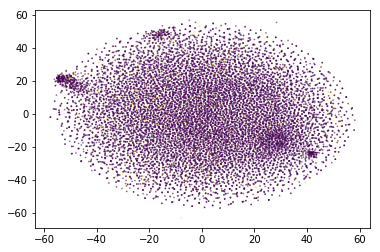

In [41]:
from sklearn.manifold import TSNE 
X = x_test
# tsne = TSNE(n_components=2, init='pca', random_state=501)
tsne = TSNE(n_components=2, init='random', random_state=501)
X_tsne = tsne.fit_transform(X)

plt.figure()
plt.scatter(X_tsne[:,0],X_tsne[:,1],c=y_test, s=0.5, alpha = 0.5)
plt.savefig('C:/Users/Crow/Desktop/Embedding_test_random_t-SNE_600.png', dpi=600)


In [31]:
X_tsne

array([[ 12.961186 , -12.500977 ],
       [ -1.9334552,  -5.334407 ],
       [  3.4114842,  -4.1672797],
       ...,
       [ -2.9549046, -10.844057 ],
       [  8.863941 ,  -6.65918  ],
       [ -4.5478153,  18.891653 ]], dtype=float32)

Org data dimension is 130. Embedded data dimension is 2


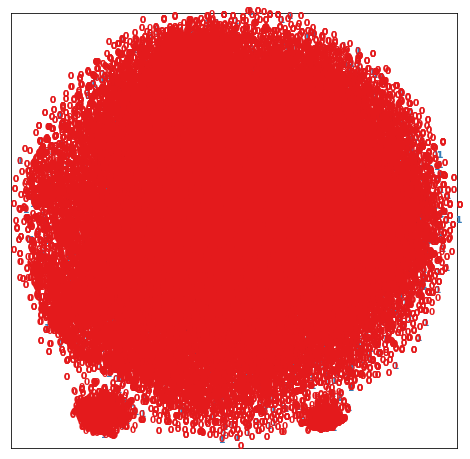

In [32]:
print("Org data dimension is {}. Embedded data dimension is {}".format(X.shape[-1], X_tsne.shape[-1]))

'''嵌入空间可视化'''
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)  # 归一化
plt.figure(figsize=(8, 8))
for i in range(X_norm.shape[0]):
    plt.text(X_norm[i, 0], X_norm[i, 1], str(y_train[i]), color=plt.cm.Set1(y_train[i]), 
             fontdict={'weight': 'bold', 'size': 9})
plt.xticks([])
plt.yticks([])
plt.show()

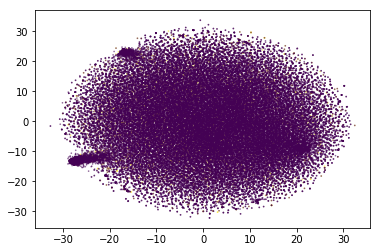

In [38]:
# 第二种t-SNE绘图

plt.figure()
plt.scatter(X_tsne[:,0],X_tsne[:,1],c=y_train, s=0.5, alpha = 0.5)

plt.show()

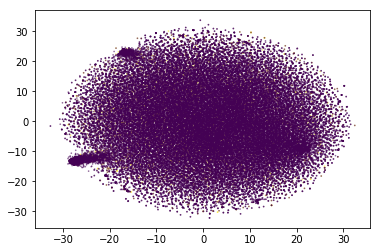